In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
input_path = '/Users/ytu/data/biddings.csv'

In [3]:
data = pd.read_csv(input_path)
print(data.shape)

(1000000, 89)


### Explore input data

Only ~0.2% of rows have `convert = true`

In [8]:
pd.value_counts(data['convert'])[1]/data.shape[0] * 100

0.1908

#### Sample the same number of rows where `convert = false` and  `convert = true`

In [4]:
def down_sampling(minority_ratio=1, majority_to_minority=1):
    convert1_sample = data.loc[data['convert'] == 1] * minority_ratio
    convert0_sample = data.loc[data['convert'] == 0].sample(majority_to_minority * len(convert1_sample))

    # shuffle
    sample = pd.concat([convert0_sample, convert1_sample]).sample(frac=1)
    
    features = sample.drop('convert', axis=1)
    labels = sample.convert

    print("features: {}, lables = {}".format(features.shape, labels.shape))
        
    return (np.array(features), np.array(labels))


(features, labels) = down_sampling()

features: (3816, 88), lables = (3816,)


#### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

Cross validation with mean accuracy as test metric

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_curve

# Returns mean accuracies and aucs
def train_kfold(n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    accuracies = []
    fprs = []
    tprs = []
    aucs = []
    
    for train_index, test_index in kf.split(features):
    #     print("TRAIN:", train_index, "TEST:", test_index)
        feature_train, feature_test = features[train_index], features[test_index]
        label_train, label_test = labels[train_index], labels[test_index]

        regression = LogisticRegression(penalty='l2')
        model = regression.fit(feature_train, label_train)
        predicted_scores = model.predict_proba(feature_test)[:,1]
        
        accuracies.append(model.score(feature_test, label_test))
        
        fpr, tpr, thresholds = roc_curve(label_test, predicted_scores)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
    
    return accuracies, fprs, tprs, aucs

We use ROC_AUC (Receiver operating characteristic area under curve) as the main metric rather than accuracy because the label distribution is highly unbalanced. But since we are using under-sampled data here, we should look at accuracy as well.

First try different number of folds, and see if there is any difference in AUC

In [9]:
for i, n_splits in enumerate(range(2, 6)):
    accuracies, fprs, tprs, aucs = train_kfold(n_splits)
    print("splits: {}, accuracy: {}, auc: {}".format(n_splits, np.mean(accuracies), np.mean(aucs)))


splits: 2, accuracy: 0.6339098532494759, auc: 0.6784454161723426
splits: 3, accuracy: 0.6263102725366877, auc: 0.671435976593448
splits: 4, accuracy: 0.6357442348008386, auc: 0.682208254255441
splits: 5, accuracy: 0.6360117475108589, auc: 0.6821499131856299


There is very little difference with number of folds. This makes sense because we are under-sampling,
and taining data is small even if splits = 2. Go ahead with 4 splits and plot the ROC curve, where AUC is around 68.2%

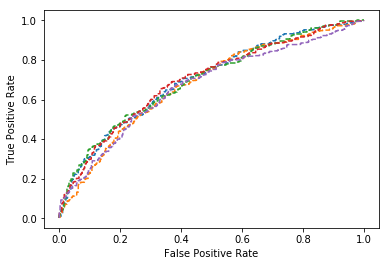

In [12]:
accuracies, fprs, tprs, aucs = train_kfold(5)
for i in range(5):
    plt.plot(fprs[i], tprs[i], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    

However, we don't have to down sample at a 1:1 ratio of labels (convert = 0 vs. convert = 1).
Try increasing the ratio to increase the sample size expotentially.
Accuracy improves up to 99% as the 0/1 ratio approaches the true distribution, whic AUC is stagnent.
This is due to most of the accuracy gains in fewer false positives


In [16]:
for majority_to_minority in [4, 8, 16, 32, 64, 128]:
    (features, labels) = down_sampling(majority_to_minority=majority_to_minority)
    accuracies, fprs, tprs, aucs = train_kfold(2)
    print("0:1 ratio: %d, accuracy: %0.3f, auc: %0.3f" % (
        majority_to_minority, np.mean(accuracies), np.mean(aucs)))

features: (9540, 88), lables = (9540,)
0:1 ratio: 4, accuracy: 0.802, auc: 0.685
features: (17172, 88), lables = (17172,)
0:1 ratio: 8, accuracy: 0.889, auc: 0.693
features: (32436, 88), lables = (32436,)
0:1 ratio: 16, accuracy: 0.941, auc: 0.688
features: (62964, 88), lables = (62964,)
0:1 ratio: 32, accuracy: 0.970, auc: 0.688
features: (124020, 88), lables = (124020,)
0:1 ratio: 64, accuracy: 0.985, auc: 0.683
features: (246132, 88), lables = (246132,)
0:1 ratio: 128, accuracy: 0.992, auc: 0.692


In [17]:
# Without KFold
from sklearn.model_selection import train_test_split
def train(features, labels, test_size=0.33, penalty='l2', class_weight=None, C=1.0, fit_intercept=True, intercept_scaling=1.0):
    feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=test_size)
    
    regression = LogisticRegression(penalty=penalty, class_weight=class_weight, C=C,
                                   fit_intercept=fit_intercept, intercept_scaling=intercept_scaling)
    model = regression.fit(feature_train, label_train)
    predicted_scores = model.predict_proba(feature_test)[:,1]
    predicted = model.predict(feature_test)
    accuracy = model.score(feature_test, label_test)
    fpr, tpr, thresholds = roc_curve(label_test, predicted_scores)
    return accuracy, fpr, tpr, label_test, predicted


Try different sampling ratios, we see AUC increases as ratio increase, but the gain is in false/postive nagatives
with sacrifice in true postives. This is due to the lack of postive samples

features: (9540, 88), lables = (9540,)
majority_to_minority: 4, accuracy: 0.800, fpr: 0.383, tpr: 0.573, auc: 0.685
[[2461   37]
 [ 593   58]]
features: (32436, 88), lables = (32436,)
majority_to_minority: 16, accuracy: 0.941, fpr: 0.433, tpr: 0.627, auc: 0.698
[[10068     1]
 [  635     0]]
features: (124020, 88), lables = (124020,)
majority_to_minority: 64, accuracy: 0.985, fpr: 0.554, tpr: 0.749, auc: 0.708
[[40326     0]
 [  601     0]]


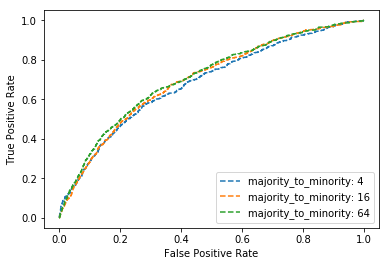

In [19]:
# 4, 16, 64
from sklearn.metrics import confusion_matrix

for majority_to_minority in [4, 16, 64]:
    (features, labels) = down_sampling(majority_to_minority=majority_to_minority)
    accuracy, fpr, tpr, label_test, predicted = train(features, labels)
    area_under_curve = auc(fpr, tpr)
    print("majority_to_minority: %d, accuracy: %0.3f, fpr: %0.3f, tpr: %0.3f, auc: %0.3f" % (
        majority_to_minority, accuracy, np.mean(fpr), np.mean(tpr), area_under_curve))
    
    # true negatives is C_{0,0}, false negatives is C_{1,0},
    # true positives is C_{1,1} and false positives is C_{0,1}.
    print(confusion_matrix(label_test, predicted))
    
    plt.plot(fpr, tpr, label="majority_to_minority: %d" % majority_to_minority, linestyle='--')
    plt.legend(loc='lower right')

    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Try L1 penalty
No meaningful improvement on AUC

In [21]:
(features, labels) = down_sampling(majority_to_minority=64)
accuracy, fpr, tpr, label_test, predicted = train(features, labels, penalty='l1')
area_under_curve = auc(fpr, tpr)
print("accuracy: %0.3f, fpr: %0.3f, tpr: %0.3f, auc: %0.3f" % (
    accuracy, np.mean(fpr), np.mean(tpr), area_under_curve))

# true negatives is C_{0,0}, false negatives is C_{1,0},
# true positives is C_{1,1} and false positives is C_{0,1}.
print(confusion_matrix(label_test, predicted))


features: (124020, 88), lables = (124020,)
accuracy: 0.985, fpr: 0.552, tpr: 0.731, auc: 0.689
[[40293     0]
 [  634     0]]


Try balanced class weights

In [23]:
(features, labels) = down_sampling(majority_to_minority=64)
accuracy, fpr, tpr, label_test, predicted = train(features, labels, penalty='l2', class_weight='balanced')
area_under_curve = auc(fpr, tpr)
print("accuracy: %0.3f, fpr: %0.3f, tpr: %0.3f, auc: %0.3f" % (
    accuracy, np.mean(fpr), np.mean(tpr), area_under_curve))

# true negatives is C_{0,0}, false negatives is C_{1,0},
# true positives is C_{1,1} and false positives is C_{0,1}.
print(confusion_matrix(label_test, predicted))

features: (124020, 88), lables = (124020,)
accuracy: 0.662, fpr: 0.555, tpr: 0.736, auc: 0.685
[[26710 13610]
 [  233   374]]


#### SGD with Over Sampling

In [25]:
from sklearn.linear_model import SGDClassifier

def over_sampling(minority_ratio=1, majority_to_minority=1):
    convert1_sample = data.loc[data['convert'] == 1] * minority_ratio
    convert0_sample = data.loc[data['convert'] == 0].sample(majority_to_minority * len(convert1_sample))
    
    sample_array = [convert0_sample]
    for i in range(120):
        sample_array.append(convert1_sample)
        
    # shuffle
    sample = pd.concat(sample_array).sample(frac=1)
    
    features = sample.drop('convert', axis=1)
    labels = sample.convert
        
    return (np.array(features), np.array(labels))

def sgd_kfold(sgd, features, labels, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    accuracies = []
    fprs = []
    tprs = []
    areas_under_curves = []
    
    for train_index, test_index in kf.split(features):
    #     print("TRAIN:", train_index, "TEST:", test_index)
        feature_train, feature_test = features[train_index], features[test_index]
        label_train, label_test = labels[train_index], labels[test_index]

        model = sgd.fit(feature_train, label_train)
        predicted_scores = model.predict_proba(feature_test)[:,1]
        predicted = model.predict(feature_test)
        accuracy = model.score(feature_test, label_test)
        fpr, tpr, thresholds = roc_curve(label_test, predicted_scores)

        accuracies.append(accuracy)
        fprs.append(fpr)
        tprs.append(tpr)
        areas_under_curves.append(auc(fpr, tpr))
    
    return accuracies, fprs, tprs, areas_under_curves


In [38]:
sgd = SGDClassifier(loss='log', penalty='l2',
                    learning_rate='invscaling', eta0=0.01, max_iter=32)

(features, labels) = over_sampling(majority_to_minority=128)
accuracies, fprs, tprs, areas_under_curves = sgd_kfold(sgd, features, labels, n_splits=3)

print("accuracy: %0.3f, auc: %0.3f" % (
    np.mean(accuracies), np.mean(areas_under_curves)))

accuracy: 0.653, auc: 0.708


In [37]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.004,
                    learning_rate='optimal', max_iter=32)

(features, labels) = over_sampling(majority_to_minority=128)
accuracies, fprs, tprs, areas_under_curves = sgd_kfold(sgd, features, labels, n_splits=3)

print("accuracy: %0.3f, auc: %0.3f" % (
    np.mean(accuracies), np.mean(areas_under_curves)))

accuracy: 0.654, auc: 0.708


#### Generate synthetic samples

In [9]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression

def benchmark(sampling_type,X,y):
    sgd = SGDClassifier(loss='log', penalty='l2',
                    learning_rate='invscaling', eta0=0.01, max_iter=32)
    param_grid = {'eta0':[0.0001, 0.001, 0.01, 0.1], 'penalty':['l1', 'l2'], 'power_t': [0.2, 0.5, 0.8]}
    gs = GridSearchCV(estimator=sgd, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
    gs = gs.fit(X.values, y.values.ravel())
    return sampling_type, gs.best_score_, gs.best_params_

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,y_resampled = transformer.fit_sample(X.values,y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [5]:
sample = data.sample(frac=1)
features = sample.drop('convert', axis=1)
labels = sample.convert

datasets = []
datasets.append(("base", features, labels))
datasets.append(transform(SMOTE(n_jobs=-1), features, labels))
datasets.append(transform(RandomOverSampler(), features, labels))
datasets.append(transform(NearMiss(n_jobs=-1), features, labels))
datasets.append(transform(RandomUnderSampler(), features, labels))
# datasets.append(transform(SMOTEENN(), features, labels))
# datasets.append(transform(SMOTETomek(), features, labels))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler


In [10]:
benchmark_scores = []
for sample_type, X, y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')

______________________________________________________________
base
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  24.9s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s remaining:    0.0s


[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  25.2s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  24.3s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  21.5s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  21.7s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  20.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=  19.3s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=  21.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] .

[CV] ................ eta0=0.1, penalty=l1, power_t=0.5, total=  24.9s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  18.9s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  19.9s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  20.8s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  14.6s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  14.7s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  13.7s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 22.2min finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  43.7s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.4s remaining:    0.0s


[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  36.6s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  36.8s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  35.2s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  35.3s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  34.3s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=  36.1s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=  35.7s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] .

[CV] ................ eta0=0.1, penalty=l1, power_t=0.5, total=  38.0s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  35.8s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  35.1s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  35.2s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  24.1s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  24.2s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  24.3s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 38.1min finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  46.1s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.6s remaining:    0.0s


[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  37.6s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=  37.3s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  36.2s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  34.1s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=  38.1s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=  34.5s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=  33.9s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] .

[CV] ................ eta0=0.1, penalty=l1, power_t=0.5, total=  37.6s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  34.7s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  34.5s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=  34.3s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  23.7s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  23.9s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=  23.7s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 37.0min finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=   0.1s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.0001, penalty=l2, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.0001, penalty=l2, power_t=0.2 ............................
[CV] .

[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.5, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.5, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.5, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.8 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.2 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.2, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.5 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] ............. eta0=0.0001, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.0001, penalty=l1, power_t=0.8 ............................
[CV] .

[CV] ................ eta0=0.1, penalty=l1, power_t=0.5, total=   0.0s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.1, penalty=l1, power_t=0.8 ...............................
[CV] ................ eta0=0.1, penalty=l1, power_t=0.8, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.2 ...............................
[CV] ................ eta0=0.1, penalty=l2, power_t=0.2, total=   0.0s
[CV] eta0=0.1, penalty=l2, power_t=0.5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    2.7s finished


NearMiss has the best ROC_AUC of 0.928 with
```
eta0 = 0.1
penalty = l2
power_t = 0.2
```

In [12]:
benchmark_scores

[('base', 0.6896397217327885, {'eta0': 0.1, 'penalty': 'l2', 'power_t': 0.5}),
 ('SMOTE', 0.7108832110576512, {'eta0': 0.1, 'penalty': 'l2', 'power_t': 0.5}),
 ('RandomOverSampler',
  0.7079267195892649,
  {'eta0': 0.001, 'penalty': 'l2', 'power_t': 0.2}),
 ('NearMiss',
  0.927722812256899,
  {'eta0': 0.1, 'penalty': 'l1', 'power_t': 0.2}),
 ('RandomUnderSampler',
  0.6840248935300556,
  {'eta0': 0.01, 'penalty': 'l1', 'power_t': 0.5})]